### Importing Libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="50" alt="Gdrive-logo"/></center>
#@markdown <center><h3>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive! 
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/braintumor.zip" -d "MRI"

## Generating a dataframe from images

In [ ]:
# Set parameters
IMAGE_SIZE = (256, 256)

In [ ]:
mask_files = glob('MRI/kaggle_3m/*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]

In [ ]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,1
1,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,0
2,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,0
3,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,0
4,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,MRI/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_73...,0


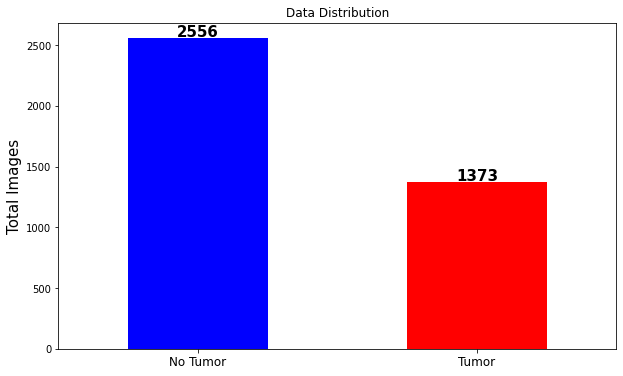

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Data Visualization

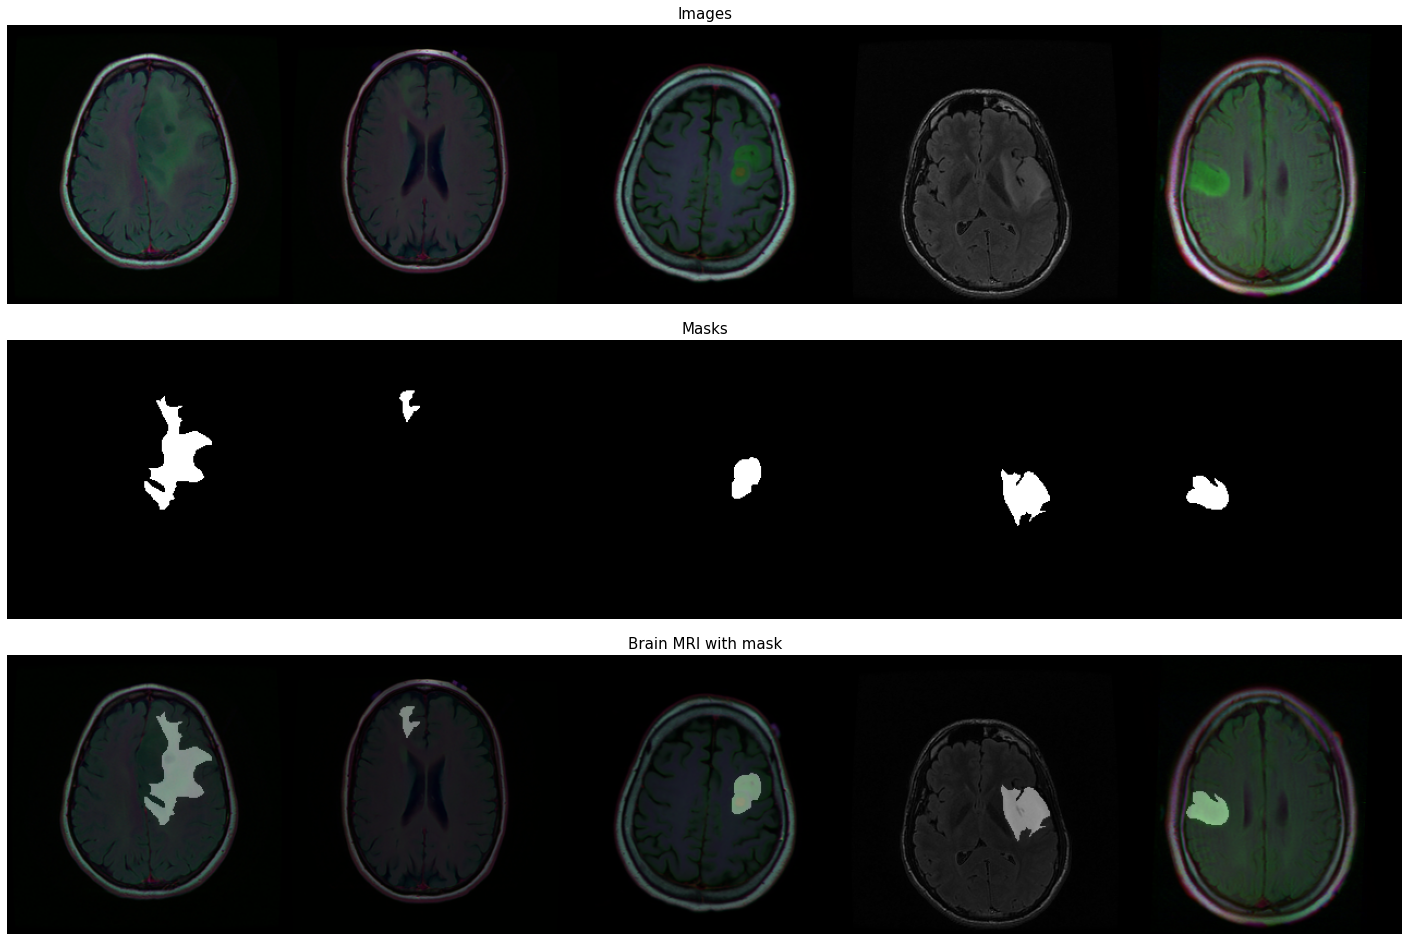

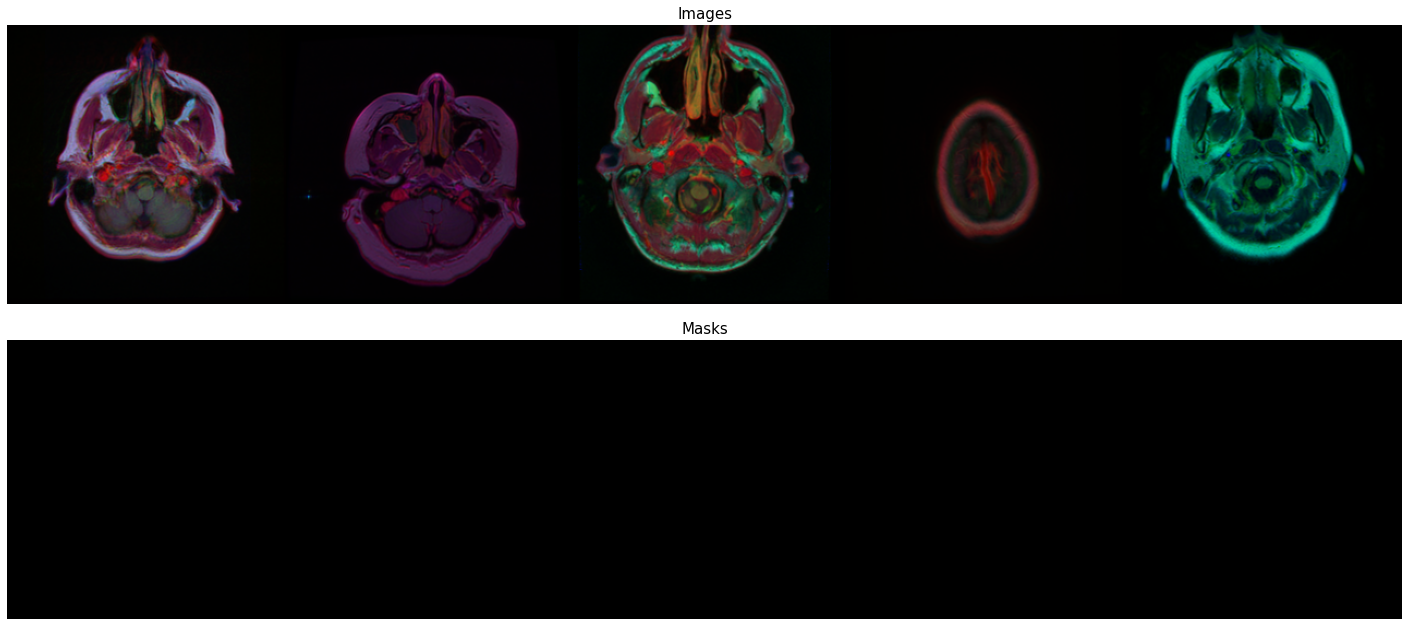

In [ ]:
df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

## Splitting dataset into train, validate, test sets

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


## Data Generator, Data Augmentation and Adjust Data

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

### Segmentation Quality Metric

In [ ]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## Model Architecture

Hyperparameter Tuning using keras tuner

In [ ]:
# import keras
# import keras_tuner
# from keras_tuner.tuners import RandomSearch
# import time
# LOG_DIR = f"2"
# #hyper parameter tuning
# image_size=256


# def UNet(hp):
#     inputs=Input((image_size,image_size,3))
#     xd1=inputs
    
#     for i in range(hp.Int('conv_blocks1',2,4,1)):
#         filters1=hp.Int('filters1_'+str(i),32,1024,32)
#         xd1=Conv2D(filters1,kernel_size=(3,3),padding='same',strides=1,activation= 'relu')(xd1)
#         xd2=MaxPooling2D((2, 2),(2, 2))(xd1)
        
#         for j in range(hp.Int('conv_blocks2',2,4,1)):
#              filters2=hp.Int('filters2_'+str(j),32,1024,32)
#              xd2=Conv2D(filters2,kernel_size=(3,3),padding='same',strides=1,activation= 'relu')(xd2)
#              xb=MaxPooling2D((2, 2),(2, 2))(xd2)
             
#              for k in range(hp.Int('bottle',2,4,1)):
#                  filtersbot=hp.Int('filtersbot_'+str(k),32,1024,32)
#                  xb=Conv2D(filtersbot,kernel_size=(3,3),padding='same',strides=1,activation= 'relu')(xb)

#              xu2=keras.layers.UpSampling2D((2, 2))(xb)
#              concat=keras.layers.Concatenate()([xu2,xd2])
#              xu2=keras.layers.Conv2D(filters2,kernel_size=(3,3),padding='same',strides=1,activation='relu')(concat)
        
#         xu1=keras.layers.UpSampling2D((2, 2))(xu2)
#         concat=keras.layers.Concatenate()([xu1,xd1])
#         xu1=keras.layers.Conv2D(filters1,kernel_size=(2,2),padding='same',strides=1,activation='relu')(concat)
        
#     outputs=Conv2D(1,(1,1),padding='same',activation='sigmoid')(xu1)
#     model=Model(inputs,outputs)
#     model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["acc"])
        
#     return model
        
# train_generator_args = dict(rotation_range=0.1,
#                             width_shift_range=0.05,
#                             height_shift_range=0.05,
#                             shear_range=0.05,
#                             zoom_range=0.05,
#                             horizontal_flip=True,
#                             vertical_flip=True,
#                             fill_mode='nearest')

# train_gen = train_generator(df_train, BATCH_SIZE,
#                                 train_generator_args,
#                                 target_size=IMAGE_SIZE)
    
# val_gen = train_generator(df_val, BATCH_SIZE,
#                                 dict(),
#                                 target_size=IMAGE_SIZE)
    

# tuner=RandomSearch(UNet, objective="acc",max_trials=1,executions_per_trial=1, directory=LOG_DIR)
# tuner.search(train_gen, epochs = 1,batch_size = 16,validation_data = val_gen)


# #tuner.search(train_gen, epochs = 1, batch_size = 32, validation_data = val_gen)








## UNET Model

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### Training

In [ ]:
# Set parameters
EPOCHS = 30
BATCH_SIZE = 16
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

filename='/content/drive/MyDrive/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

callbacks = [ModelCheckpoint('/content/drive/MyDrive/unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15),
            history_logger]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

In [ ]:
model.load_weights("/content/drive/MyDrive/unet_brainMRI_seg.hdf5")

In [ ]:
import pandas as pd
history = pd.read_csv("/content/drive/MyDrive/log.csv", sep=',', engine='python')

## Visualize model performance

Text(0.5, 1.0, 'Dice Coef')

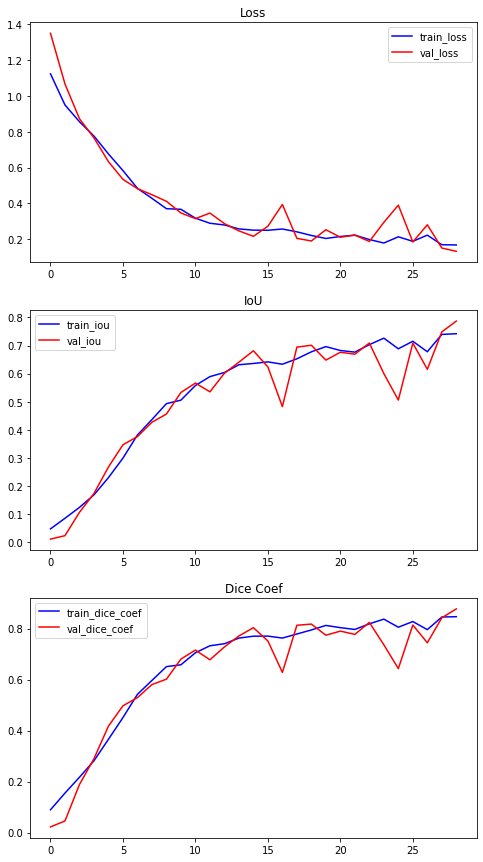

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(history['loss'], 'b-', label='train_loss')
plt.plot(history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(history['iou'], 'b-', label='train_iou')
plt.plot(history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

## Model Evaluation

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 52s 764ms/step - loss: 0.1426 - iou: 0.7734 - dice_coef: 0.8688
Test IOU:  0.7734204530715942
Test Dice Coefficent:  0.8688165545463562


## Visualizing results

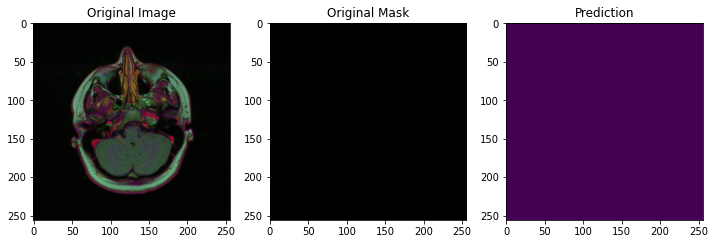

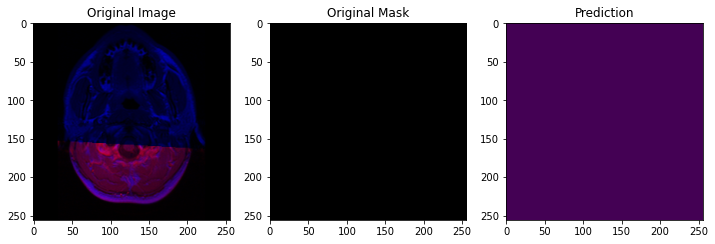

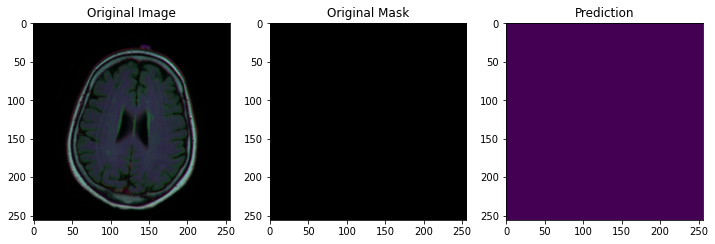

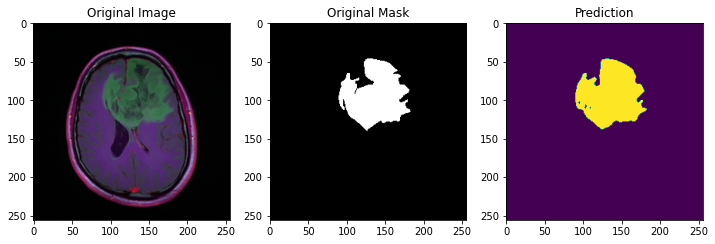

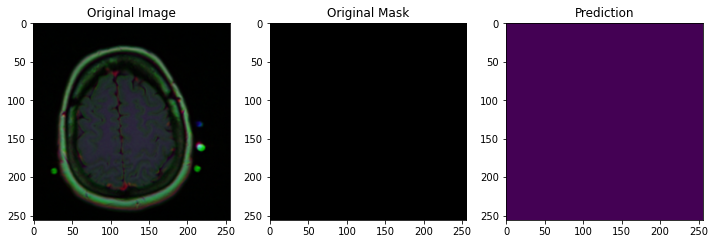

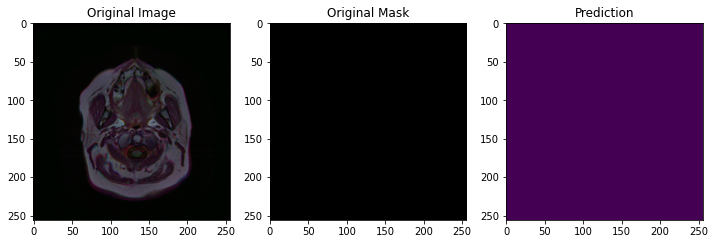

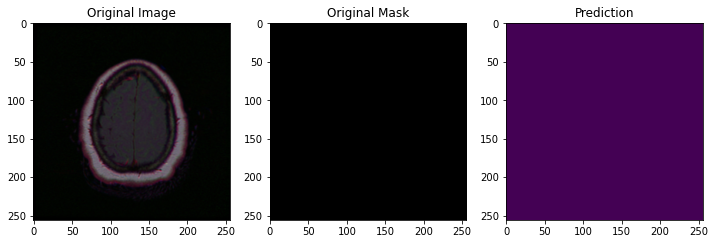

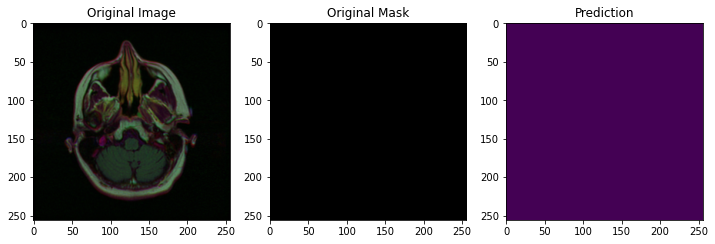

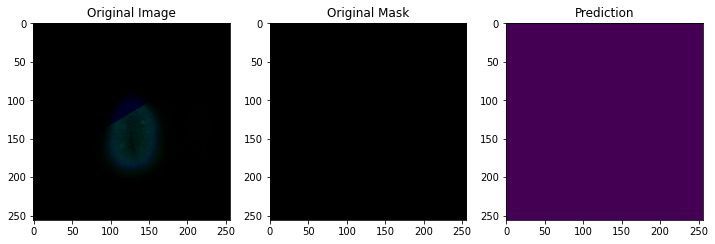

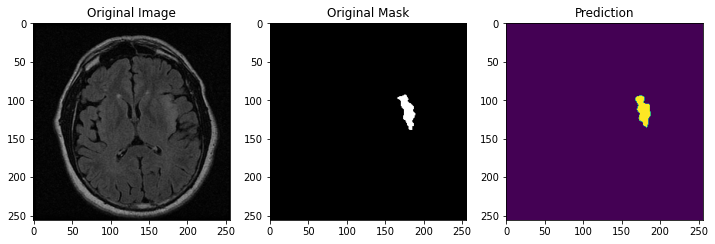

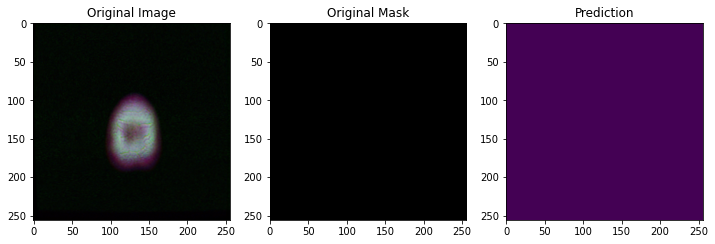

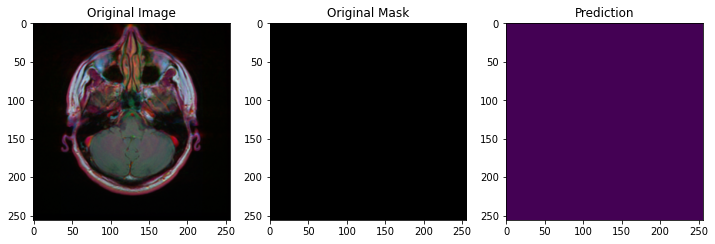

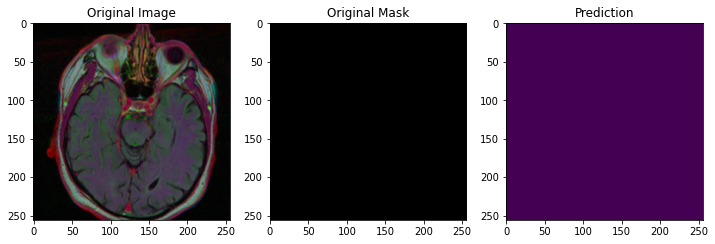

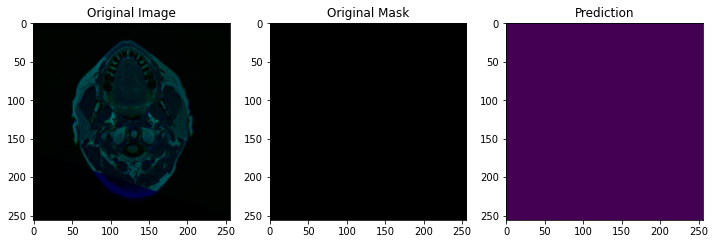

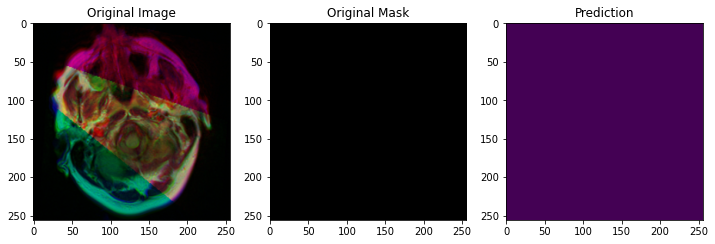

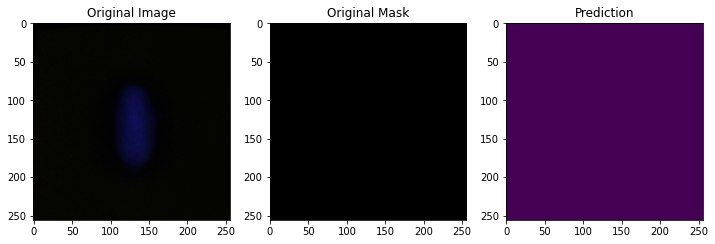

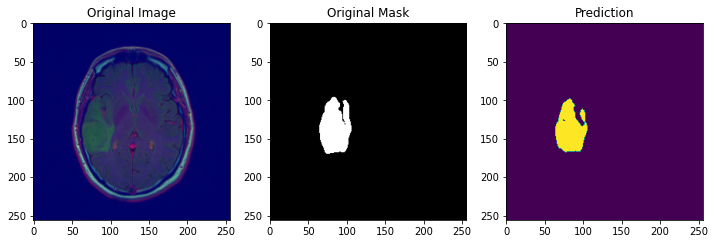

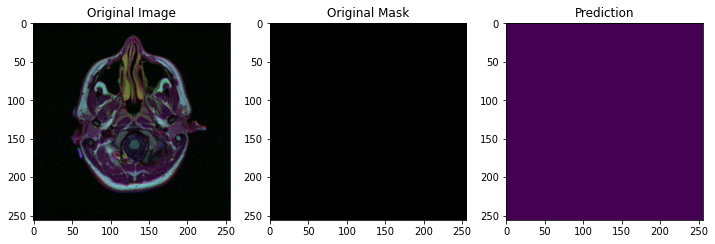

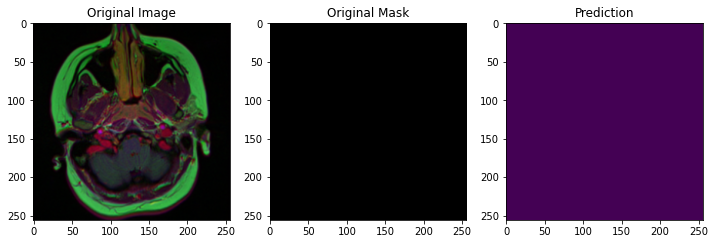

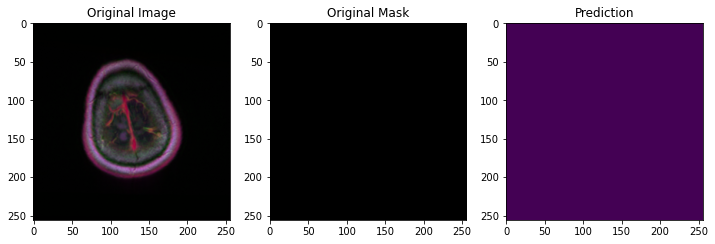

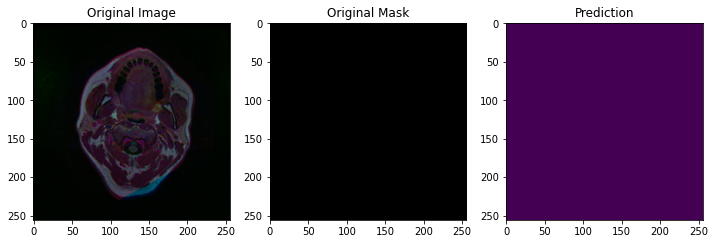

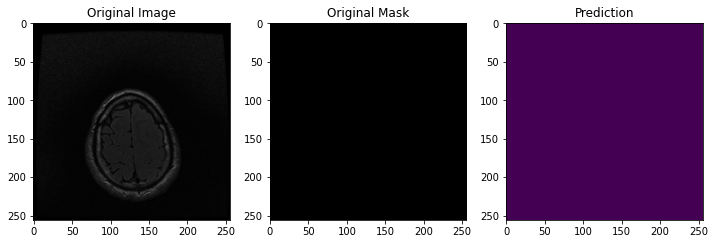

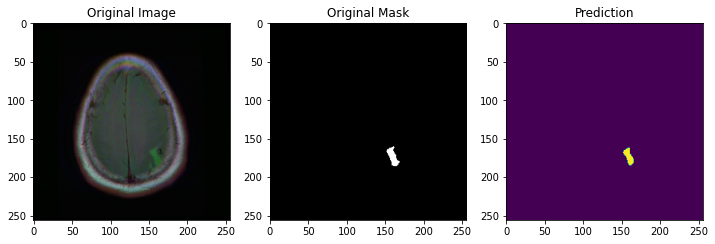

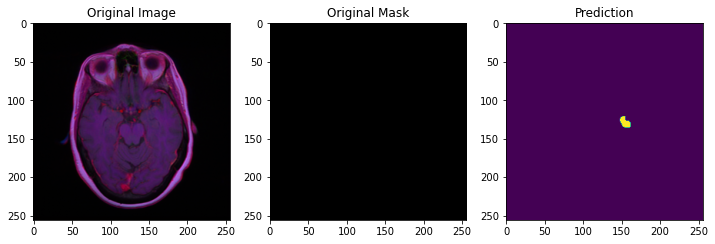

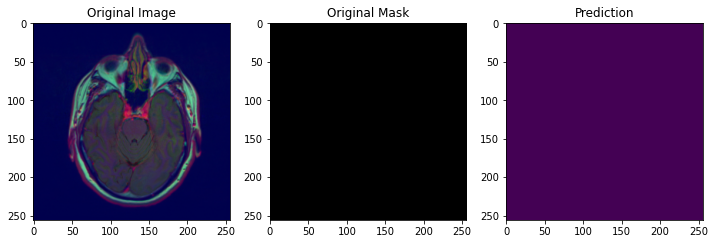

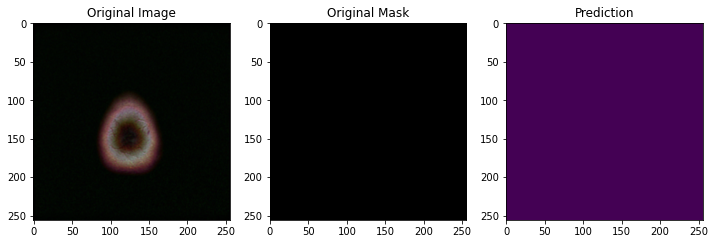

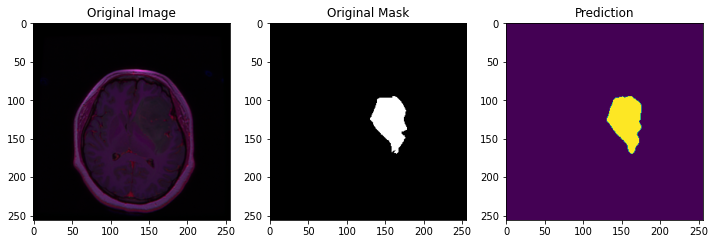

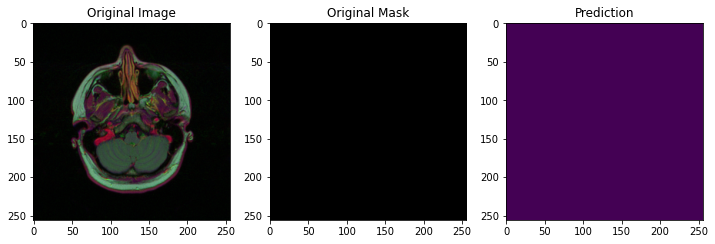

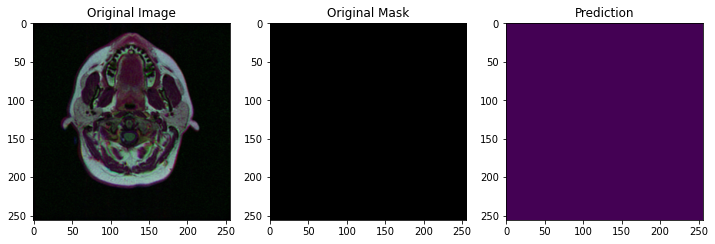

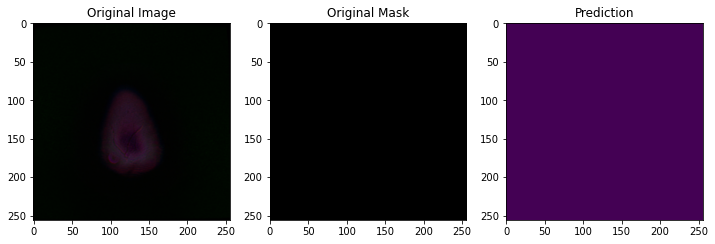

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show() 